# Fourier composition reconstruction

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf

## magnitude and phase

In [2]:
def wav_to_dataframe(file_name, piano_freqs, hop_length=512):
    '''
    Convert a sound file to a dataframe which captures the magnitude and phase of specified
    frequencies.
    '''
    # get audio signal and sampling rate
    y, sr = librosa.load(file_name, sr=None)
    # get short-time Fourier transform of the audio signal
    D = librosa.stft(y, hop_length=hop_length)
    # separate complex STFT data into magnitude and phase components
    magnitude, phase = librosa.magphase(D)
    # Loop over each piano key frequency, find the closest matching frequency from the STFT,
    # and capture its magnitude and phase. Create a dictionary of the magnitude and phase of
    # each of the frequencies.
    data = {}
    for idx, piano_freq in enumerate(piano_freqs):
        closest_idx = np.argmin(np.abs(librosa.fft_frequencies(sr=sr) - piano_freq))
        data[f'frequency_{piano_freq}_magnitude'] = magnitude[closest_idx]
        data[f'frequency_{piano_freq}_phase'] = np.angle(phase[closest_idx])
    df = pd.DataFrame(data)
    return df

def reconstruct_from_piano_keys(df, sr=22050, hop_length=256):
    total_frames = len(df) # total number of frames (or time steps) in the dataframe
    reconstructed_signal = np.zeros(total_frames * hop_length)
    '''
    Loop over each frame in the dataframe. For each of the piano key frequencies,
    reconstruct the signal for that frame and add it to the total reconstructed signal.
    '''
    for idx, row in df.iterrows():
        for piano_freq in piano_freqs:
            time = np.arange(hop_length) / sr
            mag = row[f'frequency_{piano_freq}_magnitude']
            phase = row[f'frequency_{piano_freq}_phase']
            frame_signal = mag * np.sin(2 * np.pi * piano_freq * time + phase)
            start_idx = idx * hop_length
            end_idx = start_idx + hop_length
            reconstructed_signal[start_idx:end_idx] += frame_signal
    # normalize signal to avoid clipping
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))
    return reconstructed_signal

In [3]:
file_name = "input.wav"
#piano_freqs = [85, 260, 550, 880, 1320, 1760, 2640, 3520, 5280, 7040]
piano_freqs = [
    85, 110, 130, 165, 220, 260, 330, 390, 440, 520, 550, 660, 780, 880, 1040, 1100, 1320,
    1560, 1760, 2080, 2200, 2640, 3120, 3520, 4160, 4400, 5280, 6240, 7040, 8320
]
df = wav_to_dataframe(file_name, piano_freqs)
reconstructed_y = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input_using_magnitude_and_phase.wav', reconstructed_y, 22050)

In [4]:
df

,frequency_85_magnitude,frequency_85_phase,frequency_110_magnitude,frequency_110_phase,frequency_130_magnitude,frequency_130_phase,frequency_165_magnitude,frequency_165_phase,frequency_220_magnitude,frequency_220_phase,...,frequency_4400_magnitude,frequency_4400_phase,frequency_5280_magnitude,frequency_5280_phase,frequency_6240_magnitude,frequency_6240_phase,frequency_7040_magnitude,frequency_7040_phase,frequency_8320_magnitude,frequency_8320_phase
0,0.110699,-2.489839,0.078410,-0.436776,0.006071,-0.899583,0.113937,-3.068499,0.120978,2.295418,...,0.005249,1.131411,0.001973,-1.329722,0.002873,1.368139,0.002890,0.922749,0.001219,2.599853
1,0.233694,-1.906908,0.294269,0.571584,0.215312,2.622902,0.075535,-2.419362,0.045637,-1.186735,...,0.005836,1.229245,0.001000,1.941909,0.004915,-1.934099,0.002262,-0.742504,0.000690,0.149298
2,0.300485,-1.188526,0.429576,2.078287,0.322260,-0.934894,0.118927,-1.301421,0.038341,0.121270,...,0.003074,1.940425,0.001481,0.394533,0.004708,1.182063,0.003307,-0.948765,0.000611,-2.069244
3,0.142297,0.526142,0.355486,-2.684379,0.119347,1.125960,0.119888,-1.843641,0.043584,-0.098401,...,0.003229,1.996893,0.005222,2.566157,0.001491,-2.750439,0.005255,-2.581958,0.000812,0.868515
4,0.394826,1.344710,0.237119,-1.835872,0.053629,2.595981,0.093684,-2.286024,0.062204,-3.063072,...,0.002193,1.379887,0.006068,-1.639375,0.003601,-1.618872,0.000411,1.233901,0.000617,-2.754814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0.182442,0.458607,0.467995,-2.693293,0.343005,0.155608,0.280218,0.778441,0.349857,-0.369129,...,0.110551,-2.213621,0.016399,1.010846,0.001259,3.043011,0.002519,1.061675,0.000853,-2.598208
467,0.333192,2.499992,0.560525,-0.982591,0.319691,2.262586,0.169680,1.222217,0.370497,2.534390,...,0.089663,-2.289269,0.012701,3.067459,0.004171,-1.519211,0.005691,-0.027234,0.000720,-0.704740
468,0.244111,-3.073895,0.532191,0.560668,0.193722,-2.409243,0.021289,-0.509033,0.233918,-0.934258,...,0.026816,2.645490,0.016028,0.080341,0.004313,0.561274,0.014491,2.605761,0.000501,1.593348
469,0.538440,-1.036584,0.486602,1.777264,0.223796,-1.111835,0.049767,-0.945342,0.042116,2.868448,...,0.035853,0.757034,0.011656,1.367950,0.001842,0.842539,0.026516,1.379488,0.001286,-2.108532


## magnitude only

In [5]:
def wav_to_dataframe_magnitude_only(file_name, piano_freqs, hop_length=512):
    # get audio signal and sampling rate
    y, sr = librosa.load(file_name, sr=None)
    # get short-time Fourier transform of the audio signal
    D = librosa.stft(y, hop_length=hop_length)
    # separate complex STFT data into magnitude and phase components
    magnitude, _ = librosa.magphase(D) # magnitude-only reconstruction
    # Loop over each piano key frequency, find the closest matching frequency from the STFT,
    # and capture its magnitude and phase. Create a dictionary of the magnitude only of each
    # of the frequencies.
    data = {}
    for idx, piano_freq in enumerate(piano_freqs):
        closest_idx = np.argmin(np.abs(librosa.fft_frequencies(sr=sr) - piano_freq))
        data[f'Frequency_{piano_freq}_Mag'] = magnitude[closest_idx]
        # no phase information used here
    df = pd.DataFrame(data)
    return df

def reconstruct_from_piano_keys_magnitude_only(df, sr=22050, hop_length=256):
    total_frames = len(df)
    reconstructed_signal = np.zeros(total_frames * hop_length)
    '''
    Loop over each frame in the dataframe. For each of the piano key frequencies,
    reconstruct the signal for that frame and add it to the total reconstructed signal.
    '''
    for idx, row in df.iterrows():
        for piano_freq in piano_freqs:
            time = np.arange(hop_length) / sr
            mag = row[f'Frequency_{piano_freq}_Mag']
            # for magnitude-only reconstruction, the phase is set to zero
            frame_signal = mag * np.sin(2 * np.pi * piano_freq * time)
            start_idx = idx * hop_length
            end_idx = start_idx + hop_length
            reconstructed_signal[start_idx:end_idx] += frame_signal
    # normalize signal to avoid clipping
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))
    return reconstructed_signal

In [6]:
file_name = "input.wav"
#piano_freqs = [85, 260, 550, 880, 1320, 1760, 2640, 3520, 5280, 7040]
piano_freqs = [
    85, 110, 130, 165, 220, 260, 330, 390, 440, 520, 550, 660, 780, 880, 1040, 1100, 1320,
    1560, 1760, 2080, 2200, 2640, 3120, 3520, 4160, 4400, 5280, 6240, 7040, 8320
]
df = wav_to_dataframe_magnitude_only(file_name, piano_freqs)
reconstructed_y = reconstruct_from_piano_keys_magnitude_only(df)
sf.write('reconstructed_input_using_magnitude_only.wav', reconstructed_y, 22050)

In [7]:
df

,Frequency_85_Mag,Frequency_110_Mag,Frequency_130_Mag,Frequency_165_Mag,Frequency_220_Mag,Frequency_260_Mag,Frequency_330_Mag,Frequency_390_Mag,Frequency_440_Mag,Frequency_520_Mag,...,Frequency_2200_Mag,Frequency_2640_Mag,Frequency_3120_Mag,Frequency_3520_Mag,Frequency_4160_Mag,Frequency_4400_Mag,Frequency_5280_Mag,Frequency_6240_Mag,Frequency_7040_Mag,Frequency_8320_Mag
0,0.110699,0.078410,0.006071,0.113937,0.120978,0.108470,0.040765,0.027830,0.003077,0.019856,...,0.039215,0.005708,0.003166,0.006005,0.001584,0.005249,0.001973,0.002873,0.002890,0.001219
1,0.233694,0.294269,0.215312,0.075535,0.045637,0.182397,0.119087,0.010466,0.044039,0.052259,...,0.047274,0.004296,0.001418,0.007915,0.003723,0.005836,0.001000,0.004915,0.002262,0.000690
2,0.300485,0.429576,0.322260,0.118927,0.038341,0.158888,0.170883,0.027056,0.019900,0.045596,...,0.030619,0.012648,0.000561,0.003681,0.004753,0.003074,0.001481,0.004708,0.003307,0.000611
3,0.142297,0.355486,0.119347,0.119888,0.043584,0.129082,0.174988,0.018978,0.033342,0.052259,...,0.010168,0.012434,0.000800,0.004001,0.003959,0.003229,0.005222,0.001491,0.005255,0.000812
4,0.394826,0.237119,0.053629,0.093684,0.062204,0.132501,0.184245,0.043843,0.018425,0.081841,...,0.013351,0.010171,0.003878,0.002595,0.001524,0.002193,0.006068,0.003601,0.000411,0.000617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0.182442,0.467995,0.343005,0.280218,0.349857,0.168983,0.420427,0.434693,0.394482,0.885159,...,0.204695,0.019543,0.201144,0.061009,0.048347,0.110551,0.016399,0.001259,0.002519,0.000853
467,0.333192,0.560525,0.319691,0.169680,0.370497,0.068304,0.388880,0.152343,0.435626,1.542658,...,0.195294,0.027870,0.112156,0.031515,0.184417,0.089663,0.012701,0.004171,0.005691,0.000720
468,0.244111,0.532191,0.193722,0.021289,0.233918,0.100587,0.385060,0.358009,0.377839,0.779295,...,0.118745,0.041416,0.074484,0.072980,0.260021,0.026816,0.016028,0.004313,0.014491,0.000501
469,0.538440,0.486602,0.223796,0.049767,0.042116,0.127421,0.389112,0.380821,0.510789,0.817255,...,0.111844,0.030631,0.096089,0.113853,0.127585,0.035853,0.011656,0.001842,0.026516,0.001286


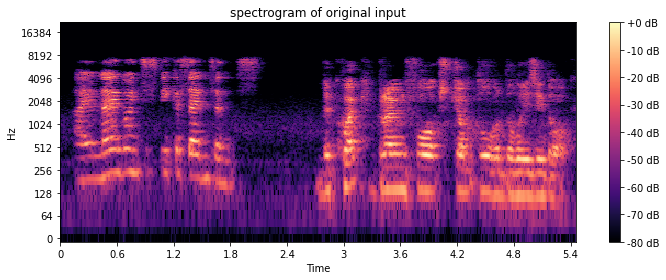

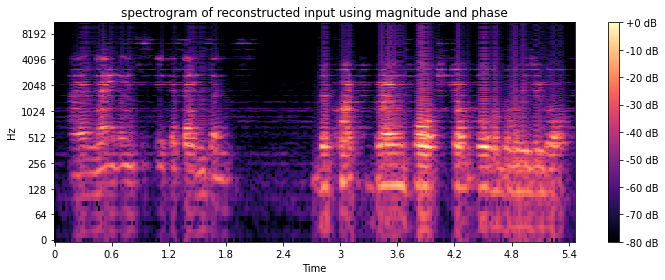

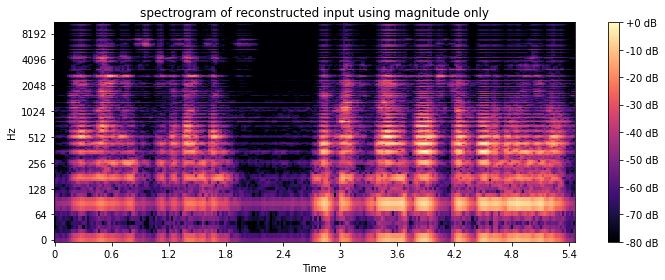

In [8]:
def display_spectrogram(y, sr, title):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# load original and reconstructed audio, both magnitude and phase, and magnitude only
y_original, sr_original = librosa.load('input.wav', sr=None)

y_reconstructed_using_magnitude_and_phase, sr_reconstructed_using_magnitude_and_phase =\
    librosa.load('reconstructed_input_using_magnitude_and_phase.wav', sr=None)

y_reconstructed_using_magnitude_only, sr_reconstructed_using_magnitude_only =\
    librosa.load('reconstructed_input_using_magnitude_only.wav', sr=None)

# display original audio spectrogram
display_spectrogram(y_original, sr_original, 'spectrogram of original input')

# display reconstructed audio spectrogram with magnitude and phase
display_spectrogram(
    y_reconstructed_using_magnitude_and_phase,
    sr_reconstructed_using_magnitude_and_phase,
    'spectrogram of reconstructed input using magnitude and phase')

# display reconstructed audio spectrogram with magnitude only
display_spectrogram(
    y_reconstructed_using_magnitude_only,
    sr_reconstructed_using_magnitude_only,
    'spectrogram of reconstructed input using magnitude only')

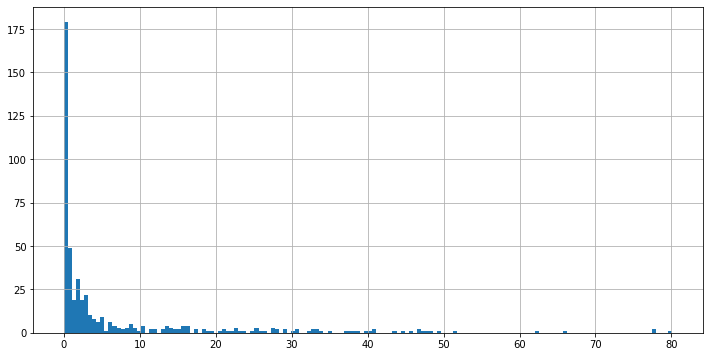

In [9]:
plt.figure(figsize=(12, 6))
df['Frequency_440_Mag'].hist(bins=150);

## experiments with rounding, means and Gaussian blurring

In [10]:
# experiments with rounding, means and Gaussian blurring

from scipy.ndimage import gaussian_filter1d

#df = wav_to_dataframe(file_name, piano_freqs)

#df = df.round(1)
#df = df.applymap(lambda x: round(x * 2) / 2)
#df = df.applymap(lambda x: round(x))

#group_ids = np.arange(len(df)) // 3
#df = df.groupby(group_ids).transform('mean')

#from scipy.ndimage import gaussian_filter1d
## apply Gaussian blur to each column
#sigma = 1  # the standard deviation for the Gaussian kernel -- adjust as needed.
#for column in df.columns:
#    df[column] = gaussian_filter1d(df[column], sigma)

#reconstructed_y = reconstruct_from_piano_keys(df)
#sf.write('reconstructed_experiments.wav', reconstructed_y, 22050)

In [11]:
file_name = "input.wav"
#piano_freqs = [85, 260, 550, 880, 1320, 1760, 2640, 3520, 5280, 7040]
piano_freqs = [
    85, 110, 130, 165, 220, 260, 330, 390, 440, 520, 550, 660, 780, 880, 1040, 1100, 1320,
    1560, 1760, 2080, 2200, 2640, 3120, 3520, 4160, 4400, 5280, 6240, 7040, 8320
]

df = wav_to_dataframe(file_name, piano_freqs)
reconstructed_y = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input.wav', reconstructed_y, 22050)

df = wav_to_dataframe(file_name, piano_freqs)
df = df.applymap(lambda x: round(x))
reconstructed_y = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input_rounded_to_integers.wav', reconstructed_y, 22050)

df = wav_to_dataframe(file_name, piano_freqs)
group_ids = np.arange(len(df)) // 3
df = df.groupby(group_ids).transform('mean')
reconstructed_y = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input_means_in_dataframe.wav', reconstructed_y, 22050)

df = wav_to_dataframe(file_name, piano_freqs)
# apply Gaussian blur to each column
sigma = 3 # the standard deviation for the Gaussian kernel -- adjust as needed
for column in df.columns:
    df[column] = gaussian_filter1d(df[column], sigma)
reconstructed_y = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input_Gaussian_blur_sigma_3.wav', reconstructed_y, 22050)

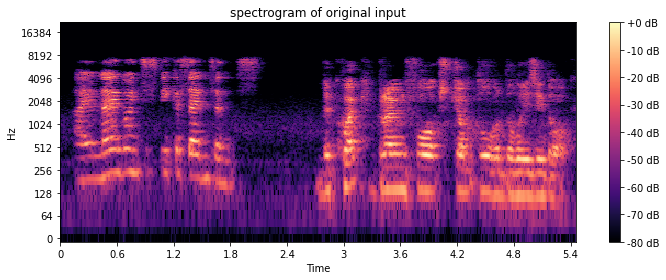

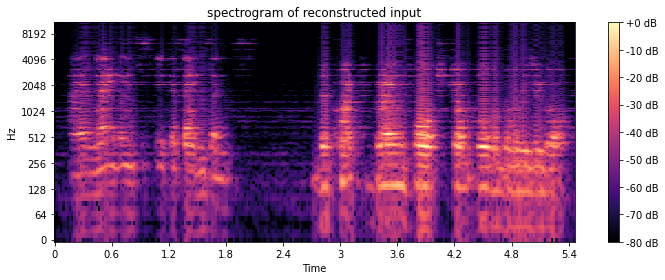

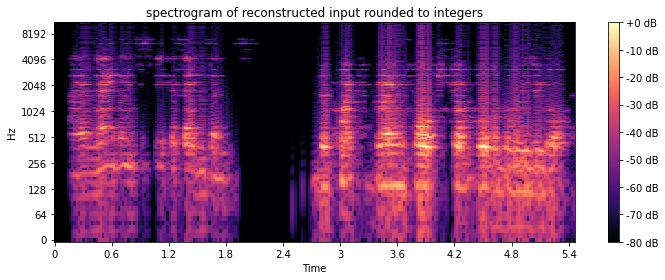

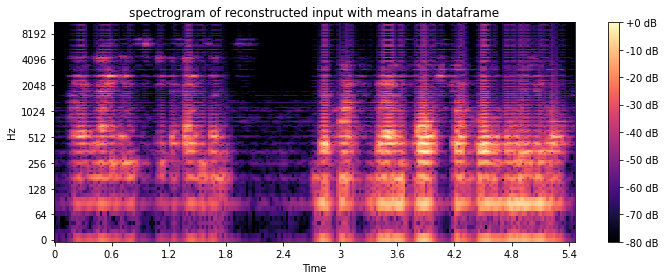

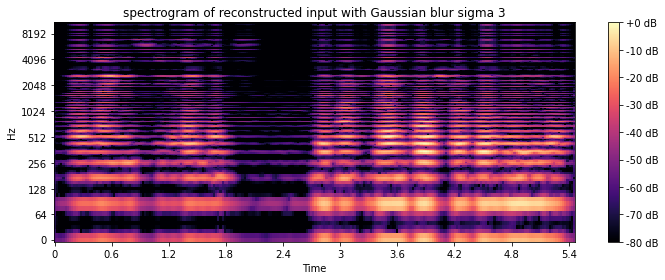

In [12]:
y_original, sr_original = librosa.load('input.wav', sr=None)
y_reconstructed, sr_reconstructed = librosa.load('reconstructed_input.wav', sr=None)
y_reconstructed_rounded_to_integers, sr_reconstructed_rounded_to_integers =\
    librosa.load('reconstructed_input_rounded_to_integers.wav', sr=None)
y_reconstructed_means_in_dataframe, sr_reconstructed_means_in_dataframe =\
    librosa.load('reconstructed_input_means_in_dataframe.wav', sr=None)
y_reconstructed_Gaussian_blur_sigma_3, sr_reconstructed_Gaussian_blur_sigma_3 =\
    librosa.load('reconstructed_input_Gaussian_blur_sigma_3.wav', sr=None)

display_spectrogram(
    y_original,
    sr_original,
    'spectrogram of original input')
display_spectrogram(
    y_reconstructed,
    sr_reconstructed,
    'spectrogram of reconstructed input')
display_spectrogram(
    y_reconstructed_rounded_to_integers,
    sr_reconstructed_rounded_to_integers,
    'spectrogram of reconstructed input rounded to integers')
display_spectrogram(
    y_reconstructed_means_in_dataframe,
    sr_reconstructed_means_in_dataframe,
    'spectrogram of reconstructed input with means in dataframe')
display_spectrogram(
    y_reconstructed_Gaussian_blur_sigma_3,
    sr_reconstructed_Gaussian_blur_sigma_3,
    'spectrogram of reconstructed input with Gaussian blur sigma 3')

## 88-key piano

In [13]:
file_name = "input.wav"
# 88 key piano
piano_freqs = [
    4186.009, 3951.066, 3729.31, 3520, 3322.438, 3135.963, 2959.955, 2793.826, 2637.02,
    2489.016, 2349.318, 2217.461, 2093.005, 1975.533, 1864.655, 1760, 1661.219, 1567.982,
    1479.978, 1396.913, 1318.51, 1244.508, 1174.659, 1108.731, 1046.502, 987.7666, 932.3275,
    880, 830.6094, 783.9909, 739.9888, 698.4565, 659.2551, 622.254, 587.3295, 554.3653,
    523.2511, 493.8833, 466.1638, 440, 415.3047, 391.9954, 369.9944, 349.2282, 329.6276,
    311.127, 293.6648, 277.1826, 261.6256, 246.9417, 233.0819, 220, 207.6523, 195.9977,
    184.9972, 174.6141, 164.8138, 155.5635, 146.8324, 138.5913, 130.8128, 123.4708, 116.5409,
    110, 103.8262, 97.99886, 92.49861, 87.30706, 82.40689, 77.78175, 73.41619, 69.29566,
    65.40639, 61.73541, 58.27047, 55, 51.91309, 48.99943, 46.2493, 43.65353, 41.20344,
    38.89087, 36.7081, 34.64783, 32.7032, 30.86771, 29.13524, 27.5
]
df = wav_to_dataframe(file_name, piano_freqs)
y_reconstructed_using_88_piano_keys = reconstruct_from_piano_keys(df)
sf.write('reconstructed_input_using_88_piano_keys.wav', reconstructed_y, 22050)

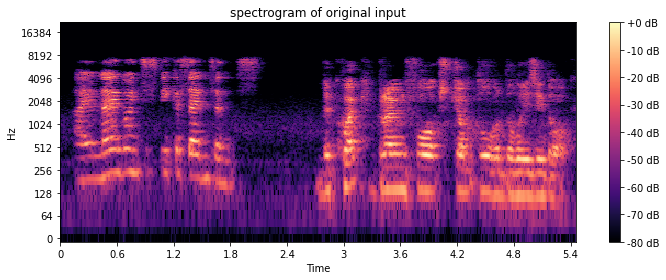

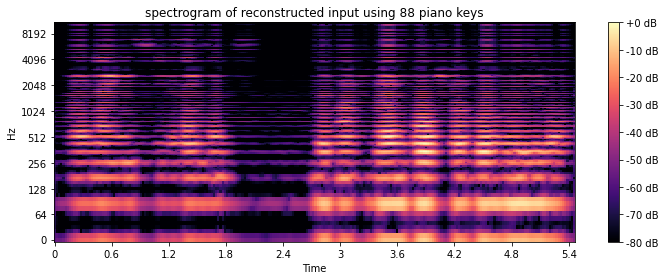

In [14]:
y_original, sr_original = librosa.load('input.wav', sr=None)
y_reconstructed_using_88_piano_keys, sr_reconstructed_using_88_piano_keys =\
    librosa.load('reconstructed_input_using_88_piano_keys.wav', sr=None)

# display original audio spectrogram
display_spectrogram(
    y_original,
    sr_original,
    'spectrogram of original input')

# display reconstructed audio spectrogram with 88-key piano
display_spectrogram(
    y_reconstructed_using_88_piano_keys,
    sr_reconstructed_using_88_piano_keys,
    'spectrogram of reconstructed input using 88 piano keys')